<a href="https://colab.research.google.com/github/JWKKWJ123/google-colab/blob/main/Copy_of_day1_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm
import torch
print("Using torch", torch.__version__)

Using torch 2.5.1+cu121


<ipython-input-20-585de448bd42>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [ ]:
torch.manual_seed(42) # Setting the seed
x = torch.Tensor(2, 3, 4)
print(x)
x = torch.Tensor([[1, 2], [3, 4]])
print(x)
x = torch.rand(2, 3, 4)
print(x)
shape = x.shape
print("Shape:", x.shape)

size = x.size()
print("Size:", size)

dim1, dim2, dim3 = x.size()
print("Size:", dim1, dim2, dim3)
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)

print("Numpy array:", np_arr)
print("PyTorch tensor:", tensor)
tensor = torch.arange(4)
np_arr = tensor.numpy()

print("PyTorch tensor:", tensor)
print("Numpy array:", np_arr)

tensor([[[0.0000e+00, 4.3912e-41, 1.8788e+31, 1.7220e+22],
         [2.1715e-18, 1.6985e+22, 1.3369e+22, 1.0374e-08],
         [8.1721e+20, 1.3109e-08, 1.0548e-08, 4.1023e-08]],

        [[1.0547e-08, 2.6729e-06, 1.4580e-19, 1.1495e+24],
         [3.0881e+29, 1.5766e-19, 7.3313e+22, 7.2151e+22],
         [2.8404e+29, 2.3089e-12, 1.9421e+31, 2.7491e+20]]])
tensor([[1., 2.],
        [3., 4.]])
tensor([[[0.8823, 0.9150, 0.3829, 0.9593],
         [0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936]],

        [[0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274],
         [0.2696, 0.4414, 0.2969, 0.8317]]])
Shape: torch.Size([2, 3, 4])
Size: torch.Size([2, 3, 4])
Size: 2 3 4
Numpy array: [[1 2]
 [3 4]]
PyTorch tensor: tensor([[1, 2],
        [3, 4]])
PyTorch tensor: tensor([0, 1, 2, 3])
Numpy array: [0 1 2 3]


In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/CV course/day1/practical1"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [ ]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


In [ ]:
class MLP_test(nn.Module):
    def __init__(self, input_size=3072, num_classes=10, hidden_sizes=[256, 128]):
        """
        Inputs:
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict. The output size of the MLP
                          should be num_classes.
            hidden_sizes - A list of integers specifying the hidden layer sizes in the MLP.
                           The MLP should have len(hidden_sizes)+1 linear layers.
        """
        super().__init__()

        # List to hold all layers
        layers = []

        # Add input layer
        in_features = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            in_features = hidden_size

        # Add output layer
        layers.append(nn.Linear(in_features, num_classes))

        # Combine all layers into a sequential model
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Apply the MLP on an input.
        Inputs:
            x - Input tensor of shape (batch_size, input_size)
        Outputs:
            Output tensor of shape (batch_size, num_classes)
        """
        return self.network(x)


class MLP(nn.Module):
    def __init__(self, input_size=3072, num_classes=10, hidden_sizes=[256, 128]):
        """
        Inputs:
            input_size - Size of the input images in pixels (e.g., 32x32x3 = 3072)
            num_classes - Number of classes we want to predict.
            hidden_sizes - List of integers specifying the hidden layer sizes in the MLP.
        """
        super().__init__()

        # List to hold all layers
        layers = []

        # Add input layer
        in_features = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            in_features = hidden_size

        # Add output layer
        layers.append(nn.Linear(in_features, num_classes))

        # Combine all layers into a sequential model
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Apply the MLP on an input.
        Inputs:
            x - Input tensor of shape (batch_size, channels, height, width)
        Outputs:
            Output tensor of shape (batch_size, num_classes)
        """
        # Flatten the input: (batch_size, 3, 32, 32) -> (batch_size, 3072)
        x = x.view(x.size(0), -1)
        return self.network(x)






# Let's test the MLP implementation
input_size = np.random.randint(low=64, high=3072)
num_classes = np.random.randint(low=5, high=20)
hidden_sizes = [np.random.randint(low=32, high=256) for _ in range(np.random.randint(low=1, high=3))]
my_mlp = MLP(input_size=input_size, num_classes=num_classes, hidden_sizes=hidden_sizes)
my_mlp.to(device)
random_input = torch.randn(32, input_size, device=device)
random_output = my_mlp(random_input)
assert random_output.shape[0] == random_input.shape[0]
assert random_output.shape[1] == num_classes

In [ ]:
#difine a SGD optimizer
class OptimizerTemplate:

    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        #SGD
        p.data -= self.lr * p.grad

class SGDMomentum(OptimizerTemplate):

    def __init__(self, params, lr, momentum=0.9):
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t

    def update_param(self, p):
        #SGD
        p.data -= self.lr * p.grad





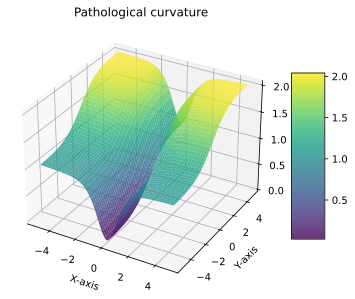

In [ ]:
#fig.gca doesn't work in this enviroment

def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

'''
def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca(projection='3d') if plot_3d else fig.gca()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid([x,y], indexing='ij')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()
'''

def plot_curve(curve_fn, x_range=(-5, 5), y_range=(-5, 5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure(figsize=(6, 6))

    # Create a 3D or 2D axis depending on the plot_3d flag
    if plot_3d:
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = fig.add_subplot(111)

    # Generate grid points
    x = torch.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / 100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1] - y_range[0]) / 100.)
    X, Y = torch.meshgrid(x, y, indexing="xy")

    # Compute function values
    Z = curve_fn(X, Y)

    if plot_3d:
        # 3D surface plot
        surf = ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy(), cmap=cmap, alpha=0.8)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    else:
        # 2D contour plot
        cont = ax.contourf(X.numpy(), Y.numpy(), Z.numpy(), cmap=cmap)
        fig.colorbar(cont, ax=ax, shrink=0.5, aspect=5)

    # Set titles and labels
    ax.set_title(title)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    if plot_3d:
        ax.set_zlabel("Z-axis")

    return fig, ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()





In [ ]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5, 5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    # Initialize the parameters as a learnable tensor
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])  # Initialize optimizer with the weights

    list_points = []

    for _ in range(num_updates):
        optimizer.zero_grad()
        # Compute the loss
        w1, w2 = weights[0], weights[1]
        loss = curve_func(w1, w2)
        # Log the current weights and loss
        list_points.append(torch.tensor([w1.item(), w2.item(), loss.item()]))
        # Perform backpropagation
        loss.backward()
        optimizer.step()

    # Stack all points and convert to numpy
    points = torch.stack(list_points, dim=0).numpy()
    return points
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))

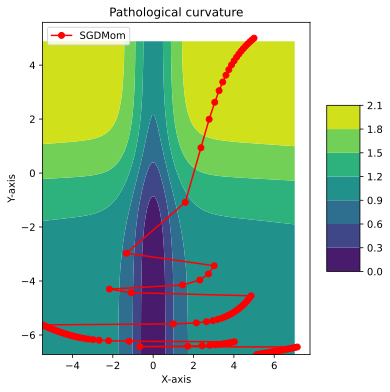

In [ ]:
fig, ax = plot_curve(
    curve_fn=pathological_curve_loss,  # Use 'curve_fn' instead of 'curve_func'
    x_range=(all_points[:, 0].min(), all_points[:, 0].max()),
    y_range=(all_points[:, 1].min(), all_points[:, 1].max()),
    plot_3d=False
)

# Use the axis object `ax` to plot
ax.plot(SGDMom_points[:, 0], SGDMom_points[:, 1], color="red", marker="o", zorder=2, label="SGDMom")
plt.legend()
plt.show()

In [ ]:
def train_model(model, optimizer, train_data_loader, val_data_loader, num_epochs=25, model_name="MyMLP"):
    """
    Train and validate the model.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    best_val_acc = -1.0  # Initialize best validation accuracy

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Track accuracy over epochs
    train_acc_history = []
    val_acc_history = []

    # Training loop
    for epoch in range(1, num_epochs + 1):
        # Set model to training mode
        model.train()
        running_corrects = 0
        total_samples = 0

        for imgs, labels in train_data_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

        # Compute epoch training accuracy
        train_acc = running_corrects / total_samples
        train_acc_history.append(train_acc)
        print(f"Epoch {epoch}/{num_epochs} - Training Accuracy: {train_acc:.4f}")

        # Validation loop every 5 epochs
        if epoch % 5 == 0 or epoch == num_epochs:
            model.eval()  # Set model to evaluation mode
            val_corrects = 0
            val_samples = 0

            with torch.no_grad():
                for imgs, labels in val_data_loader:
                    imgs, labels = imgs.to(device), labels.to(device)

                    outputs = model(imgs)
                    _, preds = torch.max(outputs, 1)
                    val_corrects += torch.sum(preds == labels).item()
                    val_samples += labels.size(0)

            val_acc = val_corrects / val_samples
            val_acc_history.append(val_acc)
            print(f"Epoch {epoch}/{num_epochs} - Validation Accuracy: {val_acc:.4f}")

            # Save the best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                save_model(model, model_name)
                print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")

    # Load the best model after training
    load_model(model, model_name)
    print(f"Best model loaded with validation accuracy: {best_val_acc:.4f}")
    return train_acc_history, val_acc_history

def save_model(model, model_name):
    """Save the model to a file."""
    torch.save(model.state_dict(), f"{model_name}.pth")

def load_model(model, model_name):
    try:
        model.load_state_dict(torch.load(f"{model_name}.pth"))
        print(f"Model loaded from {model_name}.pth")
    except FileNotFoundError:
        print(f"Error: {model_name}.pth not found. Make sure the model file exists.")






In [ ]:
@torch.no_grad()
def test_model(model, data_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0

    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        # Compute the number of correct predictions
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

In [ ]:
def save_model(model, model_name):
    torch.save(model.state_dict(), f"{model_name}.pth")
    print(f"Model saved to {model_name}.pth")


def load_model(model, model_name):
    model.load_state_dict(torch.load(f"{model_name}.pth"))
    print(f"Model loaded from {model_name}.pth")

In [ ]:
# Dataset statistics for normalizing the input values to zero mean and one std
DATA_MEANS = [0.491, 0.482, 0.447]
DATA_STD = [0.247, 0.243, 0.261]

# Transformations are applied on images when we want to access them. Here, we push the images into a tensor
# and normalize the values. However, you can use more transformations, like augmentations to prevent overfitting.
# Feel free to experiment with augmentations here once you have a first running MLP, but remember to not apply
# any augmentations on the test data!
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

# Loading the training dataset. We need to split it into a training and validation part
main_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=data_transforms, download=True)
train_set, val_set = torch.utils.data.random_split(main_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=data_transforms, download=True)

# Create data loaders for later
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=3)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
input_size = 32 * 32 * 3  # CIFAR-10 images are 32x32 with 3 channels
num_classes = 10          # CIFAR-10 has 10 classes
hidden_sizes = [256, 128] # You can experiment with different sizes

#build the MLP
model = MLP(input_size=32*32*3, num_classes=10, hidden_sizes=[256, 128])
#model = MLP(input_size=input_size, num_classes=num_classes, hidden_sizes=hidden_sizes)

In [ ]:

class SGDMomentum(OptimizerTemplate):
    def __init__(self, params, lr, momentum=0.9):
        super().__init__(params, lr)
        self.momentum = momentum  # Momentum coefficient (beta_1)
        self.param_momentum = {id(p): torch.zeros_like(p.data) for p in self.params}  # Store m_t for each parameter

    def update_param(self, p):
        # Retrieve the momentum buffer for the parameter
        v = self.param_momentum[id(p)]

        # Update the momentum: v_t = beta_1 * v_t-1 + grad
        v.mul_(self.momentum).add_(p.grad)

        # Update the parameter: theta = theta - lr * v_t
        p.data -= self.lr * v


optimizer = SGDMomentum(model.parameters(), lr=0.01, momentum=0.9)
train_acc, val_acc = train_model(
    model=model,
    optimizer=optimizer,
    train_data_loader=train_loader,
    val_data_loader=val_loader,
    num_epochs=10,
    model_name="CIFAR10_MLP_SGDMomentum"
)
load_model(model, "CIFAR10_MLP")

# Test the model
test_accuracy = test_model(model, test_loader)
print(f"Final Test Accuracy on CIFAR-10: {test_accuracy:.4f}")

Epoch 1/10 - Training Accuracy: 0.6871
Epoch 2/10 - Training Accuracy: 0.7016
Epoch 3/10 - Training Accuracy: 0.7187
Epoch 4/10 - Training Accuracy: 0.7311
Epoch 5/10 - Training Accuracy: 0.7432
Epoch 5/10 - Validation Accuracy: 0.5246
Best model saved with validation accuracy: 0.5246
Epoch 6/10 - Training Accuracy: 0.7579
Epoch 7/10 - Training Accuracy: 0.7703
Epoch 8/10 - Training Accuracy: 0.7850
Epoch 9/10 - Training Accuracy: 0.7898
Epoch 10/10 - Training Accuracy: 0.8050
Epoch 10/10 - Validation Accuracy: 0.5084
Model loaded from CIFAR10_MLP_SGDMomentum.pth
Best model loaded with validation accuracy: 0.5246
Error: CIFAR10_MLP.pth not found. Make sure the model file exists.


<ipython-input-63-86a879ddb094>:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_name}.pth"))


Test Accuracy: 0.5228
Final Test Accuracy on CIFAR-10: 0.5228
